In [2]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:24<00:00, 121MB/s]
100% 2.29G/2.29G [00:24<00:00, 101MB/s]


In [3]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [4]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [5]:
# Define paths to the dataset directories
train_dir = '/content/chest_xray/train'
test_dir  = '/content/chest_xray/test'


In [6]:
# Data augmentation: Add rotations, zooms, and shifts to augment the dataset and improve generalization
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Adjusting batch size as before
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=16,
    class_mode='binary'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,                         # Directory for test images
    target_size=(150, 150),           # Resize all images to 150x150 pixels
    batch_size=16,                    # Batch size for test images
    class_mode='binary'          # binary for binary classification
)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


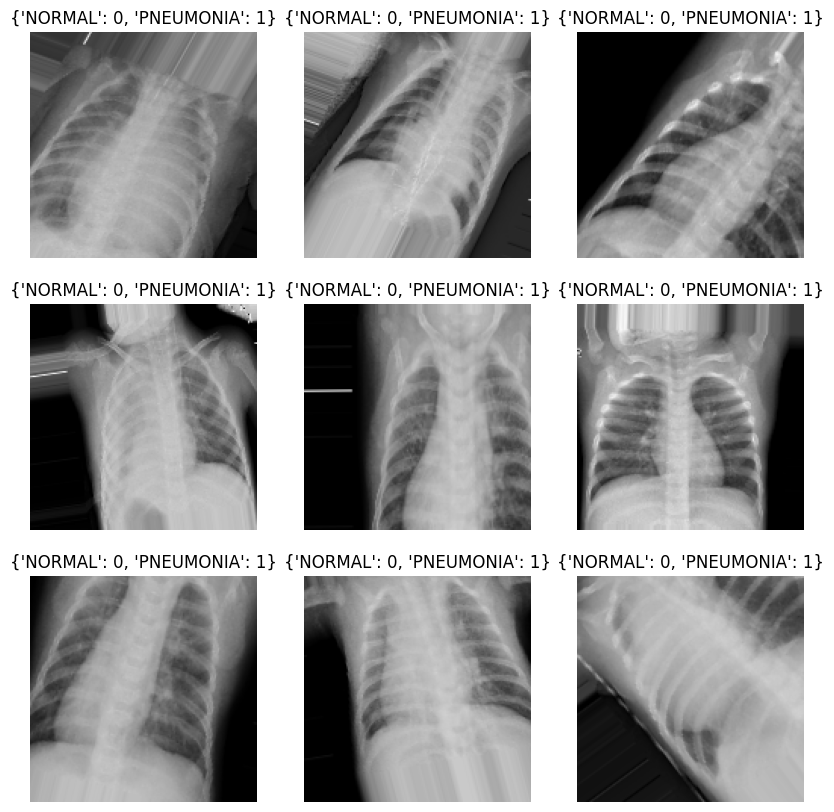

In [7]:
import matplotlib.pyplot as plt

# Get a batch of images and labels from the training generator
images, labels = next(train_generator)

# Display the first 9 images in the batch
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(train_generator.class_indices)
    plt.axis('off')
plt.show()


In [8]:
import numpy as np
# Analyze class distribution in the training set
class_counts = train_generator.classes
unique_classes, class_frequencies = np.unique(class_counts, return_counts=True)
class_labels = list(train_generator.class_indices.keys())

print("Class Distribution in Training Set:")
for i in range(len(unique_classes)):
  print(f"{class_labels[i]}: {class_frequencies[i]}")

# Analyze image shapes and sizes
image_shapes = [img.shape for img in images]
print("\nImage Shapes:")
print(f"Unique shapes: {np.unique(image_shapes)}")


# Analyze label distribution in the test set
test_class_counts = test_generator.classes
test_unique_classes, test_class_frequencies = np.unique(test_class_counts, return_counts=True)
test_class_labels = list(test_generator.class_indices.keys())

print("\nClass Distribution in Test Set:")
for i in range(len(test_unique_classes)):
  print(f"{test_class_labels[i]}: {test_class_frequencies[i]}")



Class Distribution in Training Set:
NORMAL: 1341
PNEUMONIA: 3875

Image Shapes:
Unique shapes: [  3 150]

Class Distribution in Test Set:
NORMAL: 234
PNEUMONIA: 390


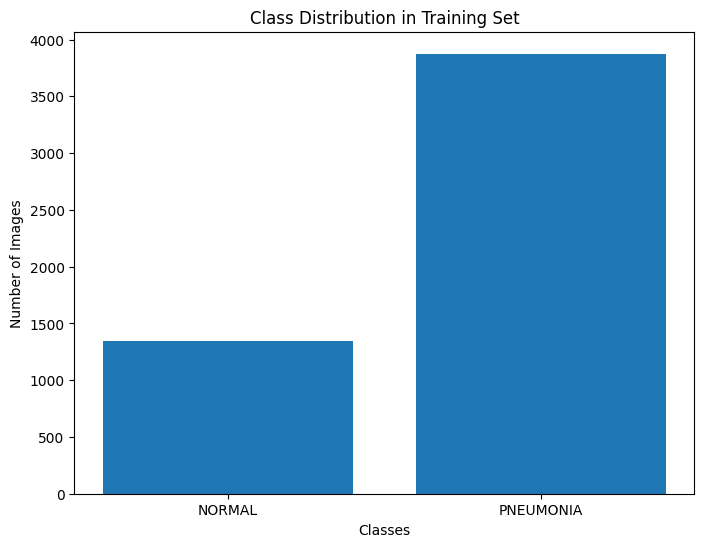

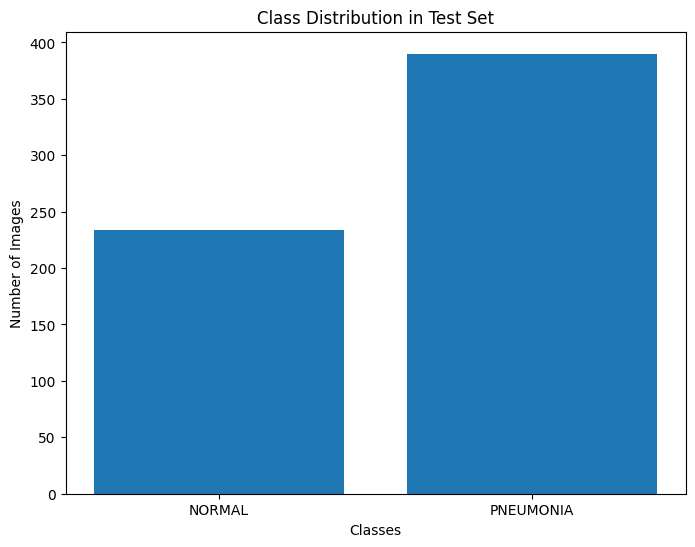

In [9]:
import matplotlib.pyplot as plt

# Visualize class distribution in the training set
plt.figure(figsize=(8, 6))
plt.bar(class_labels, class_frequencies)
plt.title('Class Distribution in Training Set')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()

# Visualize class distribution in the test set
plt.figure(figsize=(8, 6))
plt.bar(test_class_labels, test_class_frequencies)
plt.title('Class Distribution in Test Set')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()

In [10]:
total_train_images = sum(class_frequencies)
total_test_images = sum(test_class_frequencies)

print("\nPercentage of each class in Training Set:")
for i in range(len(unique_classes)):
  percentage = (class_frequencies[i] / total_train_images) * 100
  print(f"{class_labels[i]}: {percentage:.2f}%")


print("\nPercentage of each class in Test Set:")
for i in range(len(test_unique_classes)):
  percentage = (test_class_frequencies[i] / total_test_images) * 100
  print(f"{test_class_labels[i]}: {percentage:.2f}%")



Percentage of each class in Training Set:
NORMAL: 25.71%
PNEUMONIA: 74.29%

Percentage of each class in Test Set:
NORMAL: 37.50%
PNEUMONIA: 62.50%


In [11]:
from tensorflow.keras.regularizers import l2

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3), kernel_regularizer=l2(0.001)),
    MaxPooling2D(2, 2),
    Dropout(0.4),  # Increased dropout

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(2, 2),
    Dropout(0.4),  # Increased dropout

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(2, 2),
    Dropout(0.4),  # Increased dropout

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.6),  # Stronger dropout before final dense layer
    Dense(1, activation='sigmoid')
])

# Compile the model with L2 regularization
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Data augmentation: Add rotations, zooms, and shifts to augment the dataset and improve generalization
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Adjusting batch size as before
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=16,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=16,
    class_mode='binary'
)

# Use early stopping to avoid overfitting again
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


326/326 ━━━━━━━━━━━━━━━━━━━━ 88s 232ms/step - accuracy: 0.7242 - loss: 1.4753 - val_accuracy: 0.6250 - val_loss: 0.7992
Epoch 2/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 131s 228ms/step - accuracy: 0.7399 - loss: 0.6828 - val_accuracy: 0.6250 - val_loss: 0.7210
Epoch 3/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 75s 228ms/step - accuracy: 0.7400 - loss: 0.6257 - val_accuracy: 0.6250 - val_loss: 0.7054
Epoch 4/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 75s 226ms/step - accuracy: 0.7430 - loss: 0.6132 - val_accuracy: 0.6250 - val_loss: 0.7138
Epoch 5/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 75s 225ms/step - accuracy: 0.7412 - loss: 0.5561 - val_accuracy: 0.6250 - val_loss: 0.6739
Epoch 6/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 83s 229ms/step - accuracy: 0.7594 - loss: 0.4731 - val_accuracy: 0.6571 - val_loss: 0.6048
Epoch 7/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 81s 226ms/step - accuracy: 0.7757 - loss: 0.4352 - val_accuracy: 0.7853 - val_loss: 0.5260
Epoch 8/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 80s 242ms/step - accuracy: 0.8136 - loss: 0.4263 - va

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,102,533 (217.83 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,068,356 (145.22 MB)

# **Evaluate the model on the test set**

In [13]:
test_loss, test_acc = model.evaluate(validation_generator, steps=validation_generator.samples // 16) # Use validation_generator
print(f'Test accuracy: {test_acc * 100:.2f}%')

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.8513 - loss: 0.4301
Test accuracy: 84.62%


In [14]:
# Use a small batch of validation data to trigger metrics
model.evaluate(validation_generator, steps=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9375 - loss: 0.4427


[0.44267404079437256, 0.9375]

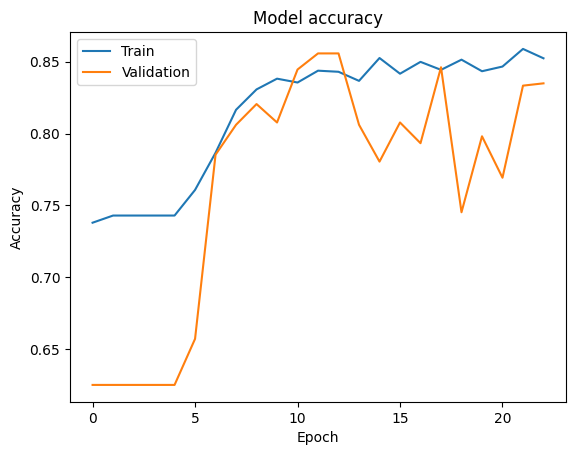

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

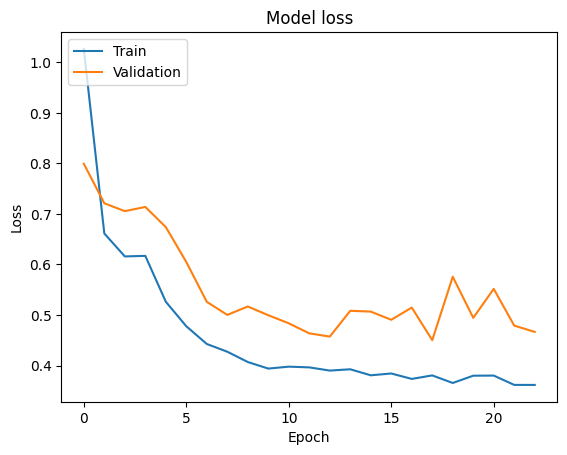

In [16]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step
Confusion Matrix:
[[ 80 154]
 [172 218]]


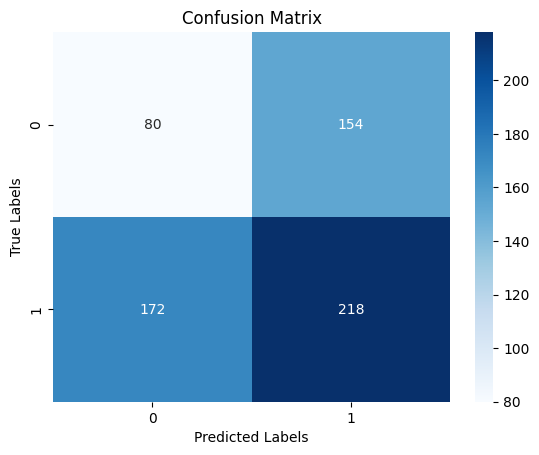

In [17]:
# prompt: gen a code for confusion matrix

from sklearn.metrics import confusion_matrix
import numpy as np

# Predict the classes for the test set
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1) if Y_pred.shape[1] > 1 else (Y_pred > 0.5).astype("int32")

# Get the true labels for the test set
Y_true = validation_generator.classes

# Generate the confusion matrix
confusion_mtx = confusion_matrix(Y_true, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_mtx)

# You can also visualize the confusion matrix using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion_mtx, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [18]:
model.save('chest_xray_model.h5')


In [7]:
from tensorflow.keras.models import load_model
model = load_model('Downloads/chest_xray_model (1).h5')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'Downloads/chest_xray_model (1).h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,179 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [3]:
import tkinter as tk
from tkinter import filedialog, messagebox
from tkinter.ttk import Progressbar
from PIL import Image, ImageTk
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import threading

model = load_model('chest_xray_model.h5')

# Define class labels
class_labels = ['Normal', 'Pneumonia']

# Function to preprocess the uploaded image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.  # Normalize the image
    return img_array

# Function to predict the class of the uploaded image
def predict_image(img_path):
    try:
        # Preprocess the image and make a prediction
        img_array = preprocess_image(img_path)
        prediction = model.predict(img_array)
        predicted_class_index = np.argmax(prediction)
        predicted_class = class_labels[predicted_class_index]
        confidence = prediction[0][predicted_class_index] * 100
        return predicted_class, confidence
    except Exception as e:
        messagebox.showerror("Prediction Error", str(e))
        return None, None

# Function to handle image upload and prediction
def upload_and_predict():
    img_path = filedialog.askopenfilename(filetypes=[("Image files", "*.jpg;*.jpeg;*.png")])
    if img_path:
        # Display the image in the GUI
        display_image(img_path)

        # Start prediction in a new thread
        thread = threading.Thread(target=start_prediction, args=(img_path,))
        thread.start()

# Function to display the image in the GUI
def display_image(img_path):
    img = Image.open(img_path)
    img = img.resize((200, 200))  # Adjust image size
    img_tk = ImageTk.PhotoImage(img)

    panel.configure(image=img_tk)
    panel.image = img_tk

# Function to start the prediction process
def start_prediction(img_path):
    # Show progress bar
    progress_bar.start()

    # Predict the result
    predicted_class, confidence = predict_image(img_path)

    if predicted_class:
        result_text.set(f"Prediction: {predicted_class} ({confidence:.2f}% confidence)")

    # Stop progress bar
    progress_bar.stop()

# Function to reset the interface
def reset_gui():
    panel.config(image="")
    result_text.set("Upload an image for prediction")
    progress_bar.stop()

# Set up the main window
root = tk.Tk()
root.title("Chest X-ray Classifier")
root.geometry("400x500")  # Adjust window size
root.resizable(False, False)

# Title and instructions
title_label = tk.Label(root, text="Chest X-ray Classifier", font=("Helvetica", 16, "bold"))
title_label.pack(pady=20)

instructions_label = tk.Label(root, text="Upload a Chest X-ray Image for Diagnosis", font=("Helvetica", 12))
instructions_label.pack(pady=10)

# Image panel
panel = tk.Label(root)
panel.pack(pady=20)

# Result label
result_text = tk.StringVar(value="Upload an image for prediction")
result_label = tk.Label(root, textvariable=result_text, font=("Helvetica", 14))
result_label.pack(pady=10)

# Progress bar
progress_bar = Progressbar(root, mode="indeterminate", length=200)
progress_bar.pack(pady=10)

# Buttons
upload_button = tk.Button(root, text="Upload and Predict", command=upload_and_predict, font=("Helvetica", 12))
upload_button.pack(pady=10)

reset_button = tk.Button(root, text="Reset", command=reset_gui, font=("Helvetica", 12))
reset_button.pack(pady=5)

exit_button = tk.Button(root, text="Exit", command=root.quit, font=("Helvetica", 12))
exit_button.pack(pady=5)

# Run the Tkinter main loop
root.mainloop()


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'chest_xray_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)